In [1]:
# Luke Graham 46419422

In [2]:
#Use this cell to import all the required libraries.
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import string

import sklearn as sk
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.preprocessing import normalize
from sklearn.decomposition import TruncatedSVD

import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk import pos_tag 
from nltk.stem import WordNetLemmatizer 

import gensim
from gensim import corpora
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import FastText

import re
import matplotlib.pyplot as plt
import spacy
import seaborn as sns
from collections import Counter
from IPython.display import display, Markdown
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

warnings.filterwarnings('ignore')


In [3]:
#your work should only start with the following code
df=pd.read_excel("Assignment_Data.xlsx")


#### <font color="red"> When you are preparing your assignment, you can use as many cells as you want. However, before submitting, please ensure that you consolidate all the necessary codes for each section into a single cell according to the template requirements. Failing to follow the template will lead to a loss of marks.

# Data exploration

First, the raw data was cloned into a second data frame to begin the data manipulation step. I began my data exploration with determining and showing the distribution of misinformed tweets and informed tweets, to better understand the dataset. I then wanted to know more about where the tweets came from, so I displayed a graphic showing the distribution of User Countries and also displayed the Top 10 Authors within the dataset. Next, to better understand the tweets content and find more stop words to remove, I created graphics for the 20 most used words (after stop word removal) in tweets and headlines. Finally, to again understand what the majority of the tweets were about, I built an LDA model to display The 5 Most Prevalent Topics within the data. This was most informative, as it showed most tweet topics revolved around presidential elections, covid and taxes. 

I removed the ‘user_following’, ‘user_friends’ and ‘user_tweet_count_lists’  as they were demmed Low Importance. All Null values were replaced in the ‘user_country’ column with Unknown, to reduce the loss of data. These unique countries were then split into their own columns where 1 = True and 0 = False. The rows containing Null values where then dropped from my dataset.


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/lukegraham/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lukegraham/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


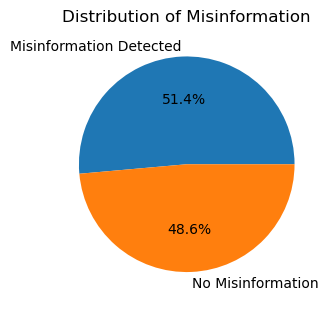

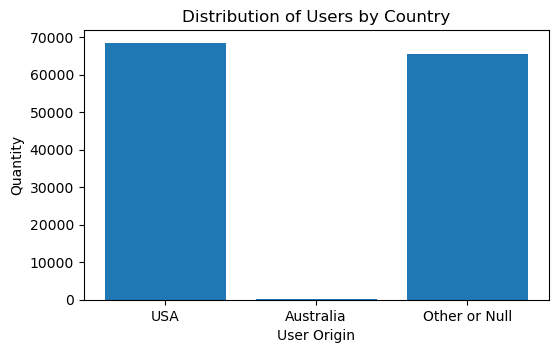

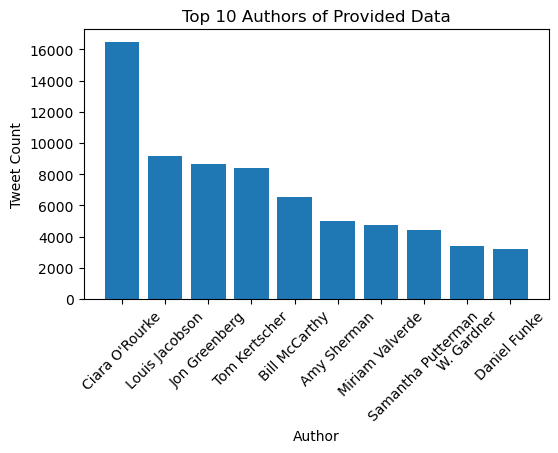

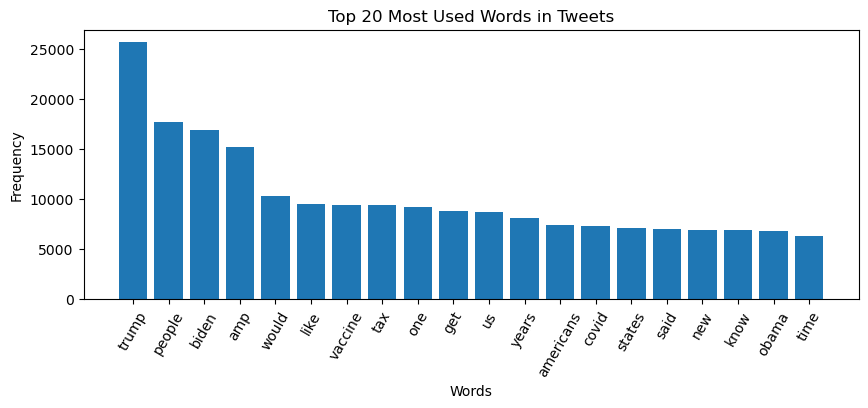

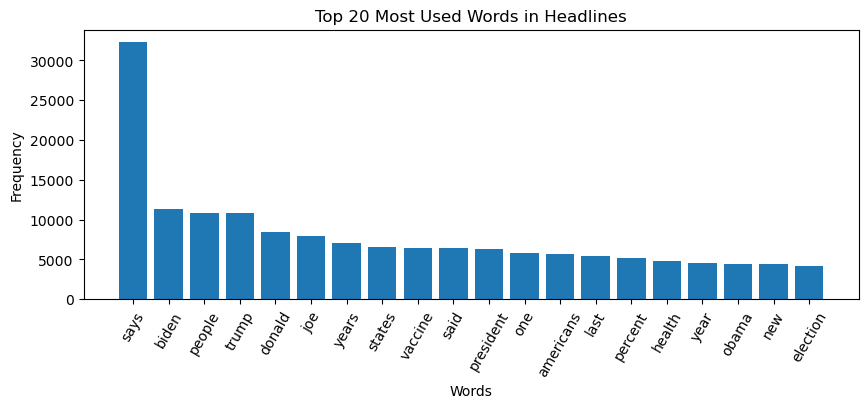

### 5 Most Popular Tweet Topics

,Weight,Topic Array
2,0.076,"[trump, biden, obama, president, amp]"
0,0.061,"[tax, jobs, rate, taxes, wage]"
3,0.057,"[vaccine, covid, people, health, get]"
4,0.047,"[election, fraud, voter, vote, votes]"
1,0.044,"[people, states, border, world, marijuana]"


In [4]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Clone the data 
data_clone = df.copy()

### View the distribution of misinformation 
missinformation_quantity = data_clone['misinformation'].value_counts()
graph_labels = missinformation_quantity.index.map({1.0: 'Misinformation Detected', 0.0: 'No Misinformation'})
plt.figure(figsize=(5, 3.5))
plt.pie(missinformation_quantity, labels=graph_labels, autopct='%1.1f%%')
plt.title('Distribution of Misinformation')
plt.show()



### Check unique types of countries
unique_countries = data_clone['user_country'].unique()
# Only returned Aus, US or Null
us_counter = 0
aus_counter = 0
other_counter = 0
for country in data_clone['user_country']:
    if country == 'US':
        us_counter += 1
    elif country == 'AU':
        aus_counter += 1
    else:
        other_counter += 1
graph2_labels = ['USA', 'Australia', 'Other or Null']
values = [us_counter, aus_counter, other_counter]
plt.figure(figsize=(6, 3.5))
plt.bar(graph2_labels, values)
plt.title('Distribution of Users by Country')
plt.xlabel('User Origin')
plt.ylabel('Quantity')
plt.show()



### Check unique types of authors
unique_authors = data_clone['news_author'].unique()
author_dict = {}
for author in data_clone['news_author']:
    if author in author_dict:
        author_dict[author] += 1
    else:
        author_dict[author] = 1
top_authors = sorted(author_dict.items(), key=lambda x: x[1], reverse=True)[:10]
graph3_labels, author_values = zip(*top_authors)
plt.figure(figsize=(6, 3.5))
plt.bar(graph3_labels, author_values)
plt.title('Top 10 Authors of Provided Data')
plt.xlabel('Author')
plt.ylabel('Tweet Count')
plt.xticks(rotation=45)
plt.show()



### Check the most common words in tweets 
all_tweets = ' '.join(data_clone['related_tweet'].astype(str).tolist())
tweet_words = word_tokenize(all_tweets)
tweet_words = [word.lower() for word in tweet_words]
stop_words = set(stopwords.words('english'))
tweet_words = [word for word in tweet_words if word.isalpha() and word not in stop_words]
tweet_word_counts = Counter(tweet_words)
most_common_words = tweet_word_counts.most_common(20)
tweet_words, counts = zip(*most_common_words)
plt.figure(figsize=(10, 3.5))
plt.bar(tweet_words, counts)
plt.title('Top 20 Most Used Words in Tweets')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=60)
plt.show()



### Check the most common words in tweets (after personal stop word removal)
all_headlines = ' '.join(data_clone['news_headline'].astype(str).tolist())
headline_words = word_tokenize(all_headlines)
headline_words = [word.lower() for word in headline_words]
stop_words = set(stopwords.words('english'))
headline_words = [word for word in headline_words if word.isalpha() and word not in stop_words]
headline_word_counts = Counter(headline_words)
most_common_words = headline_word_counts.most_common(20)
headline_words, counts = zip(*most_common_words)
plt.figure(figsize=(10, 3.5))
plt.bar(headline_words, counts)
plt.title('Top 20 Most Used Words in Headlines')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=60)
plt.show()



### Display the 5 most spoken about topics 
tweets = data_clone['related_tweet'].astype(str).tolist()
stop_words = set(stopwords.words('english'))
processed_tweets = []
for tweet in tweets:
    tokens = word_tokenize(tweet)
    tokens = [word.lower() for word in tokens if word.isalpha() and word.lower() not in stop_words]
    processed_tweets.append(tokens)
dictionary = corpora.Dictionary(processed_tweets)
corpus = [dictionary.doc2bow(tweet) for tweet in processed_tweets]
lda_model = gensim.models.ldamodel.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)
topics_list = []
weights_list = []
topics = lda_model.print_topics(num_words=5)
for topic in topics:
    for metric in topic:
        if metric != 0 and metric != 1 and metric != 2 and metric != 3 and metric != 4:
            split_topic_string = metric.split(' + ')
            words = []
            weights = []
            for section in split_topic_string:
                weight, word = section.split('*')
                weights.append(float(weight))
                words.append(word.strip('"'))
            topics_list.append(words)
            weights_list.append(sum(weights))
data = {'Weight': weights_list, 'Topic Array': topics_list}
topics_df = pd.DataFrame(data)
topics_df = topics_df.sort_values(by='Weight', ascending=False) 
display(Markdown('### 5 Most Popular Tweet Topics'))
display(topics_df)



# Remove columns deemed unnecessary 
data_clone = data_clone.drop(columns=['user_following', 'user_friends', 'user_tweet_count_lists'])
data_clone['user_country'] = data_clone['user_country'].fillna('Unknown')

# Drop Null values
clean_data = data_clone.dropna()
clean_data = clean_data.reset_index(drop=True)

# Create new columns for each user country using integer values 1 or 0 to represent true and false respectively 
aus_user = []
us_user = []
unknown_country_user = []
for i in clean_data['user_country']:
    if i == 'US':
        unknown_country_user.append(0)
        aus_user.append(0)
        us_user.append(1)
    elif i == 'AU':
        unknown_country_user.append(0)
        aus_user.append(1)
        us_user.append(0)
    else:
        unknown_country_user.append(1)
        aus_user.append(0)
        us_user.append(0)

clean_data['aus_user'] = aus_user
clean_data['us_user'] = us_user
clean_data = clean_data.drop(columns=['user_country']) 
clean_data = clean_data.reset_index(drop=True)


# Text preparation

The process began by removing the ‘user_following’, ‘user_friends’ and ‘user_tweet_count_lists’  as they were demmed Low Importance to the model. I then replaced all Null values within the ‘user_country’ column with Unknown, to again reduce the loss of data. For processing, these countries were split into their own columns where 1 = True and 0 = False. The rows containing Null values where then dropped from my dataset and while it could be argued information missing may flag suspicious activity, it will be assumed null values accrue from web-scrapping errors. ‘related_tweets’ and the ‘news_headline’ columns were then both tokenised into individual words, then standardised by converting them all to lowercase. Removal of stop words (including my own from exploration findings) that offered little semantic value and implementation of regular expressions were both employed to further cleanse the textual data. Lemmatization via pos tagging normalised the words to their base forms. Finally, empty strings were removed.

In [6]:
# Tokenize
nltk.download('punkt')
news_headline_tokens = clean_data['news_headline'].apply(word_tokenize)
related_tweet_tokens = clean_data['related_tweet'].apply(word_tokenize)

# Case folding
news_headline_folding = news_headline_tokens.apply(lambda x: [word.lower() for word in x])
related_tweet_folding = related_tweet_tokens.apply(lambda x: [word.lower() for word in x])

# Adding my own stop words from frequent word appearances findings above
# Opted to leave like, states and one in as they may be useful pieces of information in other word meanings
personal_stopwords = ["would", "get", "us", "said", "says"]

# Stop words removal
news_headline_sw = stopwords.words("English")
related_tweet_sw = stopwords.words("English")
news_headline_swremoved = news_headline_folding.apply(lambda x: [word for word in x if word not in news_headline_sw and word not in personal_stopwords])
related_tweet_swremoved = related_tweet_tokens.apply(lambda x: [word for word in x if word not in related_tweet_sw and word not in personal_stopwords])

# Regular Expression
news_headline_re = news_headline_swremoved.apply(lambda tokens: [re.sub(r'[^a-zA-Z0-9\s]', '', token) for token in tokens])
related_tweet_re = related_tweet_swremoved.apply(lambda tokens: [re.sub(r'[^a-zA-Z0-9\s]', '', token) for token in tokens])

# Lemmatization
def lemmatize_row_pos(row, lemmatizer):
    lemma_tag = {'N': wordnet.NOUN, 'J': wordnet.ADJ, 'V': wordnet.VERB, 'R': wordnet.ADV}
    lemmatized_words = []
    for word, tag in row:
        partOfSpeech = wordnet.NOUN 
        tag_key = tag[0] 
        if tag_key in lemma_tag.keys(): 
            partOfSpeech = lemma_tag[tag_key] #!!! this was commented out
            lemmatized_words.append(lemmatizer.lemmatize(word, pos=partOfSpeech)) 
    return lemmatized_words

# Lemmatization words
My_Lemmatizer = WordNetLemmatizer() 
news_headline_lemmatizer = news_headline_re.apply(lambda x: pos_tag(x))
related_tweet_lemmatizer = related_tweet_re.apply(lambda x: pos_tag(x))

# Lemmatization rows
news_headline_final = news_headline_lemmatizer.apply(lambda x: lemmatize_row_pos(x, My_Lemmatizer))
related_tweet_final = related_tweet_lemmatizer.apply(lambda x: lemmatize_row_pos(x, My_Lemmatizer))

# Remove empty strings
news_headline_final = list(map(lambda x: list(filter(None, x)), news_headline_final))
related_tweet_final = list(map(lambda x: list(filter(None, x)), related_tweet_final))

# Normalisation of text is also used below where specific to a feature


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/lukegraham/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Feature engineering

In the pursuit of accurate identification of misinformation within tweets, I have developed eight features that will be used in classification. The use of TFDIF is to find the significant terms within the tweet and headlines to find the relevant information. Doc2Vec then captures semantic information of the texts, paired with FastText which concentrates on capturing word embeddings with a proficiency in handling misspellings and slang (perfect for tweets). Unique author ID allows the models to create a more informed model based on the author and their past tweets. Post engagement reflects how much engaging the tweet is getting and the user presence metric provides insight on credibility and influence of content creators. Both of which may be key flags for misinformation. NER was implemented to identify key entities in the texts, potentially indicating targeted misinformation campaigns. Finally, sentiment analysis highlights the emotional tone of the content. 

##### Feature 1 generation - TFIDF

In [7]:
# Joining tokenized data into strings 
token_strings_headlines = [' '.join(i) for i in news_headline_final]
token_strings_tweets = [' '.join(i) for i in related_tweet_final]

# BoW
count_vectorizer = CountVectorizer()
bag_of_words_headlines = count_vectorizer.fit_transform(token_strings_headlines)
bag_of_words_tweets = count_vectorizer.fit_transform(token_strings_tweets)

# TFIDF
TFIDF_transformer = TfidfTransformer()
TFIDF_headlines_representation = TFIDF_transformer.fit_transform(bag_of_words_headlines)
TFIDF_tweets_representation = TFIDF_transformer.fit_transform(bag_of_words_tweets)

# Create features table
features_table = clean_data.copy()
features_table = features_table.drop(columns=['news_headline', 'related_tweet', 'post_replies', 'post_retweets', 
                   'post_favourites', 'post_quotes', 'user_followers', 'user_mentions', 'user_tweets_count', 
                                    'misinformation', 'user_favourites'])
features_table = features_table.reset_index(drop=True)


##### Feature 2 generation - Doc2Vec

In [8]:
# Tokenize and tag tweets/headlines
tagged_headings = [TaggedDocument(doc, [i]) for i, doc in enumerate(news_headline_final)]
tagged_tweets = [TaggedDocument(doc, [i]) for i, doc in enumerate(related_tweet_final)]

# Train a Doc2Vec model for news headings 
headings_model = Doc2Vec(tagged_headings, vector_size=3, window=4, min_count=1)

# Train a Doc2Vec model for tweets 
tweets_model = Doc2Vec(tagged_tweets, vector_size=3, window=4, min_count=1)

# Get vector arrays 
headings_model_vectors = headings_model.dv.vectors 
tweets_model_vectors = tweets_model.dv.vectors 

# Obtain the mean of the three vectors
mean_headings_vector = headings_model_vectors.mean(axis=1)
mean_tweets_vector = tweets_model_vectors.mean(axis=1)

# Add Doc2Vec scores to feature dataframe
features_table['heading_doc2vec_mean'] = mean_headings_vector
features_table['tweets_doc2vec_mean'] = mean_tweets_vector
features_table = features_table.reset_index(drop=True)


##### Feature 3 generation - FastText (sentence mean)

In [9]:
# Traing fasttext models on both headlines and tweets
fasttext_headline_model = FastText(news_headline_final, vector_size=50, window=5)
fasttext_tweet_model = FastText(related_tweet_final, vector_size=50, window=5)

# Compute mean word embeddings for each sentence
headline_word_embeddings = [pd.DataFrame([fasttext_headline_model.wv[word] for word in sentence]).mean(axis=0) for sentence in news_headline_final]
tweet_word_embeddings = [pd.DataFrame([fasttext_tweet_model.wv[word] for word in sentence]).mean(axis=0) for sentence in related_tweet_final]

# Convert mean embeddings to DataFrames
headline_word_embeddings_df = pd.DataFrame(headline_word_embeddings)
tweet_word_embeddings_df = pd.DataFrame(tweet_word_embeddings)

# Replace NaN values with zeros
headline_word_embeddings_df = pd.DataFrame(headline_word_embeddings).fillna(0)
tweet_word_embeddings_df = pd.DataFrame(tweet_word_embeddings).fillna(0)

# Apply Truncated SVD for dimensionality reduction
svd = TruncatedSVD(n_components=1, random_state=42)

# Fit and transform SVD on headline word embeddings
headline_svd_embeddings = svd.fit_transform(headline_word_embeddings_df)

# Fit and transform SVD on tweet word embeddings
tweet_svd_embeddings = svd.fit_transform(tweet_word_embeddings_df)

# Add to features table
features_table['headline_svd_embeddings'] = headline_svd_embeddings
features_table['tweet_svd_embeddings'] = tweet_svd_embeddings


##### Feature 4 generation - Unique Author ID

In [10]:
# Add unique author id to feature dataframe
unique_authors = clean_data['news_author'].unique()
unique_authors = unique_authors.tolist()
author_id = []
for author in clean_data['news_author']:
    author_id.append(unique_authors.index(author))
features_table['author_id'] = author_id
features_table = features_table.drop(columns='news_author')
features_table = features_table.reset_index(drop=True)


##### Feature 5 generation - Post Engagement Score

In [11]:
# Clone clean data and manipulate into new dataframe
post_engagement_table = clean_data.copy()
post_engagement_table = post_engagement_table.drop(columns=['news_author', 'news_headline', 'related_tweet', 'user_followers', 
                                   'user_mentions', 'user_tweets_count', 'misinformation', 'aus_user', 'us_user', 'post_quotes'])
post_engagement_table = post_engagement_table.reset_index(drop=True)

# Normalizing the columns 
normalized_engagement_figures = normalize(post_engagement_table, axis=0)
normalized_engagement = []
for row in normalized_engagement_figures:
    normalized_engagement.append(sum(row))

# Scale by post quotes 
counter = 0
for i in normalized_engagement:
    i *= clean_data['post_quotes'][counter]
    counter += 1
    
# Add to features dataframe 
features_table['post_engagement'] = normalized_engagement
features_table = features_table.reset_index(drop=True)


##### Feature 6 generation - User Presence Score

In [12]:
# Clone clean data and manipulate into new dataframe
user_presence_table = clean_data.copy()
user_presence_table = user_presence_table.drop(columns=['news_author', 'news_headline', 'post_replies', 'post_retweets', 'post_favourites', 'post_quotes', 'related_tweet', 
                                                            'misinformation', 'aus_user', 'us_user', 'post_quotes'])
user_presence_table = user_presence_table.reset_index(drop=True)

# Normalizing the columns
user_presence_figures = normalize(user_presence_table, axis=0)
normalized_presence = []
for row in user_presence_figures:
    normalized_presence.append(sum(row))

# Scale by post quotes 
counter = 0
for i in normalized_presence:
    i *= clean_data['user_favourites'][counter]
    counter += 1
    
# Add to features dataframe 
features_table['user_presence'] = normalized_presence
features_table = features_table.reset_index(drop=True)


##### Feature 7 generation - Named Entity Recognition 

In [14]:
# Create new dataframe for tweets and headlines
tweet_df = pd.DataFrame()
headlines_df = pd.DataFrame()

# Add prerequired elements
nlp = spacy.load('en_core_web_sm')
def extract_entities(text):
    doc = nlp(text)
    entities = [ent.label_ for ent in doc.ents]
    return entities

# Apply NER on the 'related_tweet' column
tweet_NER = clean_data['related_tweet'].apply(extract_entities)

# Apply NER on the 'news_headline' column
headline_NER = clean_data['news_headline'].apply(extract_entities)

# Count the occurrences of each entity type
entity_types = nlp.get_pipe("ner").labels
for entity_type in entity_types:
    tweet_df[f'tweet_{entity_type}_count'] = tweet_NER.apply(lambda x: x.count(entity_type))
    headlines_df[f'headline_{entity_type}_count'] = headline_NER.apply(lambda x: x.count(entity_type))

# Add to features table
features_table = pd.concat([features_table, tweet_df], axis=1)
features_table = pd.concat([features_table, headlines_df], axis=1)


##### Feature 8 generation - Sentiment Analysis 

In [15]:
# Initialize VADER sentiment analyzer
nltk.download('vader_lexicon')
My_sentiment_analyser = SentimentIntensityAnalyzer()

# Perform sentiment analysis on tweets
sentimental_tweet_list = []
for sentence in clean_data['related_tweet']:
    text_score = My_sentiment_analyser.polarity_scores(sentence)['compound']
    sentimental_tweet_list.append(text_score)

# Perform sentiment analysis on headlines
sentimental_headline_list = []
for sentence in clean_data['news_headline']:
    text_score = My_sentiment_analyser.polarity_scores(sentence)['compound']
    sentimental_headline_list.append(text_score)

# Add to features table
features_table['tweet_sentiment'] = sentimental_tweet_list
features_table['headline_sentiment'] = sentimental_headline_list


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/lukegraham/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Model building & evaluation
Once you have found the most optimal model, you should only show the model building and evaluation here!

Using the features that I built earlier, I constructed and tested many models with multiple of them performing with a 0.93+ Accuracy score. I ended up deciding on the Random Forrest Classification method as it performed extremely well against all metrics of evaluation. Random Forrest was suitable for this task as it is robust to overfitting and also provides me with feature importance scores (as seen). 

First, I ran the RandomForestClassifier using 300 estimators, a max depth of 30 and a random_state of 42, using accuracy to provide an initial proof of model proficiency. The produced 0.954 accuracy from the model shows a very proficient performance. I then used to the feature importance scores to show me which of features were useful and which I could experiment with removing to improve the model. Next, I wanted to evaluate my model by applying a confusion matrix to show how many False Positives and False Negatives were predicted. As shown in the figure 714 False Negatives (predicted Misinformation, actually Not Misinformation), and 760 False Positives were predicted highlighting my error rate of only  4.40%. The precision rate of 95.83% shows that the majority of positive predications were also correct. Although, the specificity metric was a little less at  95.62% showing that my model was slightly worse at correctly classifying negative samples (not misinformation). This trade-off is visualised in the Receiver Operating Characteristic graph, displaying an almost perfect model with an area of 0.96 . While the F1 Score is excellent, it’s important to note that the class imbalance isn’t a significant issue, as misinformation isn’t uncommon on social media and not of dire consequence. Overall, the model outperformed my expectations through the application of my constructed features. Although, if I there were more time, I would experiment more with limiting my choice of features using the feature importance scores. 


### Random Forest Cross Evaluation Accuracy

Random Forest: 0.9540375803941357 



### Feature Importance Scores (Ordered by Importance)

author_id: 0.2374 (23.74%)
headline_svd_embeddings: 0.1871 (18.71%)
headline_sentiment: 0.0951 (9.51%)
tweets_doc2vec_mean: 0.0406 (4.06%)
tweet_svd_embeddings: 0.0373 (3.73%)
heading_doc2vec_mean: 0.0343 (3.43%)
tweet_sentiment: 0.0310 (3.10%)
headline_PERSON_count: 0.0294 (2.94%)
user_presence: 0.0287 (2.87%)
post_engagement: 0.0277 (2.77%)


### Confusion Matrix Evaluation

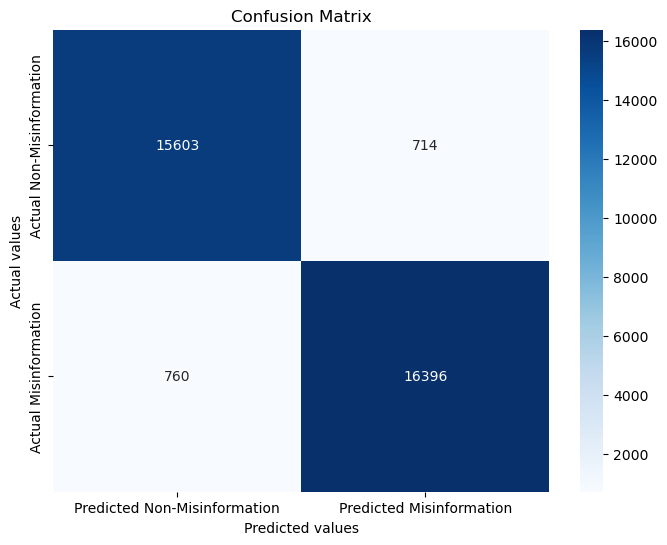

### Random Forest Model Metrics

Error Rate: 0.04403549129148865
Accuracy: 0.9559645087085114
Precision: 0.9582700175336061
Recall: 0.95570062951737
F1 Score: 0.9569835989027025
Specificity: 0.9562419562419563


### Reciever Operating Characteristic Evaluation

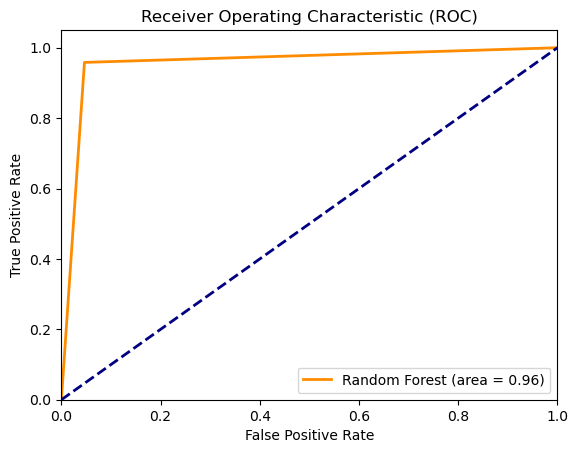

In [17]:
# Create Random Forrest Classification Model
My_RF = RandomForestClassifier(n_estimators=300, max_depth=30, random_state=42)
X = features_table
y = clean_data['misinformation']
eval_score_rf = cross_val_score(My_RF, X, y, cv=5, scoring='accuracy').mean()
display(Markdown('### Random Forest Cross Evaluation Accuracy'))
print(f"Random Forest: {eval_score_rf} \n")

# Train sample data for Importance Scores and Confusion Matrix
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
My_RF.fit(X_train, y_train)
y_pred = My_RF.predict(X_test)


# Obtain feature importance scores
feature_importance_scores = My_RF.feature_importances_
column_names = X.columns
feature_importance_tuples = list(zip(column_names, feature_importance_scores))
feature_importance_tuples_sorted = sorted(feature_importance_tuples, key=lambda x: x[1], reverse=True)
display(Markdown('### Feature Importance Scores (Ordered by Importance)'))
count = 0
for column_name, score in feature_importance_tuples_sorted:
    percentage = score * 100
    print(f"{column_name}: {score:.4f} ({percentage:.2f}%)")
    count += 1 
    if count == 10:
        break

        
# Calculate the confusion matrix
CM = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(CM, annot=True, cmap='Blues', fmt='g', xticklabels=['Predicted Non-Misinformation', 'Predicted Misinformation'], yticklabels=['Actual Non-Misinformation', 'Actual Misinformation'])
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Confusion Matrix')
display(Markdown('### Confusion Matrix Evaluation'))
plt.show()


# Compute performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
tn, fp, fn, tp = CM.ravel()
specificity = tn / (tn + fp)
error_rate = 1 - accuracy
display(Markdown('### Random Forest Model Metrics'))
print("Error Rate:", error_rate)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Specificity:", specificity)


# Build ROC Graph 
fpr, tpr, thresholds = roc_curve(y_pred, y_test)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Random Forest (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
display(Markdown('### Reciever Operating Characteristic Evaluation'))
plt.show()
